In [1]:
import numpy as np
import random
import seaborn as sns
import warnings

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from umap import UMAP


warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def read_data(filename: str, delimeter=';'):
    with open(filename, mode="r", newline='') as f:
        features = list()
        targets = list()
        for row in f:
            line = list()
            for s in row.split(delimeter):
                s = s.strip()
                if s:
                    line.append(s)
            
            t = int(line[-1])
            if t < 3:
                t -= 1
                features.append(list(map(float ,line[1:-1])))
                targets.append(t)
    return features, targets

In [3]:
def plot_results(features, targets, model):
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        return xx, yy

    def plot_contours(model, xx, yy, **params):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = plt.contourf(xx, yy, Z, **params)

        return out

    xx, yy = make_meshgrid(features[:, 0], features[:, 1])

    plt.figure(figsize=(20, 10))
    colormap = 'coolwarm'
    labels = np.unique(targets).tolist()
    palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
    cmap = sns.color_palette(colormap, as_cmap=True)

    patchs = []

    for i, color in enumerate(palette):
        patchs.append(mpatches.Patch(color=color, label=i))

    plot_contours(model, xx, yy, cmap=cmap, alpha=0.8)
    plt.scatter(features[:, 0], features[:, 1], c=targets, cmap=cmap, s=40, edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    # plt.legend(handles=patchs, loc='upper right')
    plt.show()

In [4]:
features, targets = read_data('glass.data', delimeter=',')
features = np.array(features)
features = UMAP().fit_transform(features)
features = StandardScaler().fit_transform(features)

targets = np.array(targets)

In [5]:
np.unique(targets)

array([0, 1])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, stratify=targets, shuffle=True)
x_train.shape, x_test.shape

((102, 2), (44, 2))

# SVM (SVC)

In [7]:
svc_parameters = {
    'kernel':['poly'],
    'C': np.linspace(1, 15, 10),
    'degree': np.linspace(3, 15, 15),
}

clf_svc = GridSearchCV(SVC(), svc_parameters)

In [8]:
clf_svc.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([ 1.        ,  2.27272727,  3.54545455,  4.81818182,  6.09090909,
        7.36363636,  8.63636364,  9.90909091, 11.18181818, 12.45454545,
       13.72727273, 15.        ]),
                         'degree': array([ 3.        ,  4.09090909,  5.18181818,  6.27272727,  7.36363636,
        8.45454545,  9.54545455, 10.63636364, 11.72727273, 12.81818182,
       13.90909091, 15.        ]),
                         'kernel': ['poly']})

In [9]:
clf_svc.best_params_

{'C': 3.5454545454545454, 'degree': 6.2727272727272725, 'kernel': 'poly'}

In [10]:
print(classification_report(y_train, clf_svc.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.705     0.878     0.782        49
           1      0.854     0.660     0.745        53

    accuracy                          0.765       102
   macro avg      0.779     0.769     0.763       102
weighted avg      0.782     0.765     0.763       102



In [11]:
print(classification_report(y_test, clf_svc.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.714     0.952     0.816        21
           1      0.938     0.652     0.769        23

    accuracy                          0.795        44
   macro avg      0.826     0.802     0.793        44
weighted avg      0.831     0.795     0.792        44



In [12]:
best_svc = SVC(**clf_svc.best_params_)

In [13]:
best_svc.fit(x_train, y_train)

SVC(C=3.5454545454545454, degree=6.2727272727272725, kernel='poly')

In [14]:
len(best_svc.support_vectors_)

56

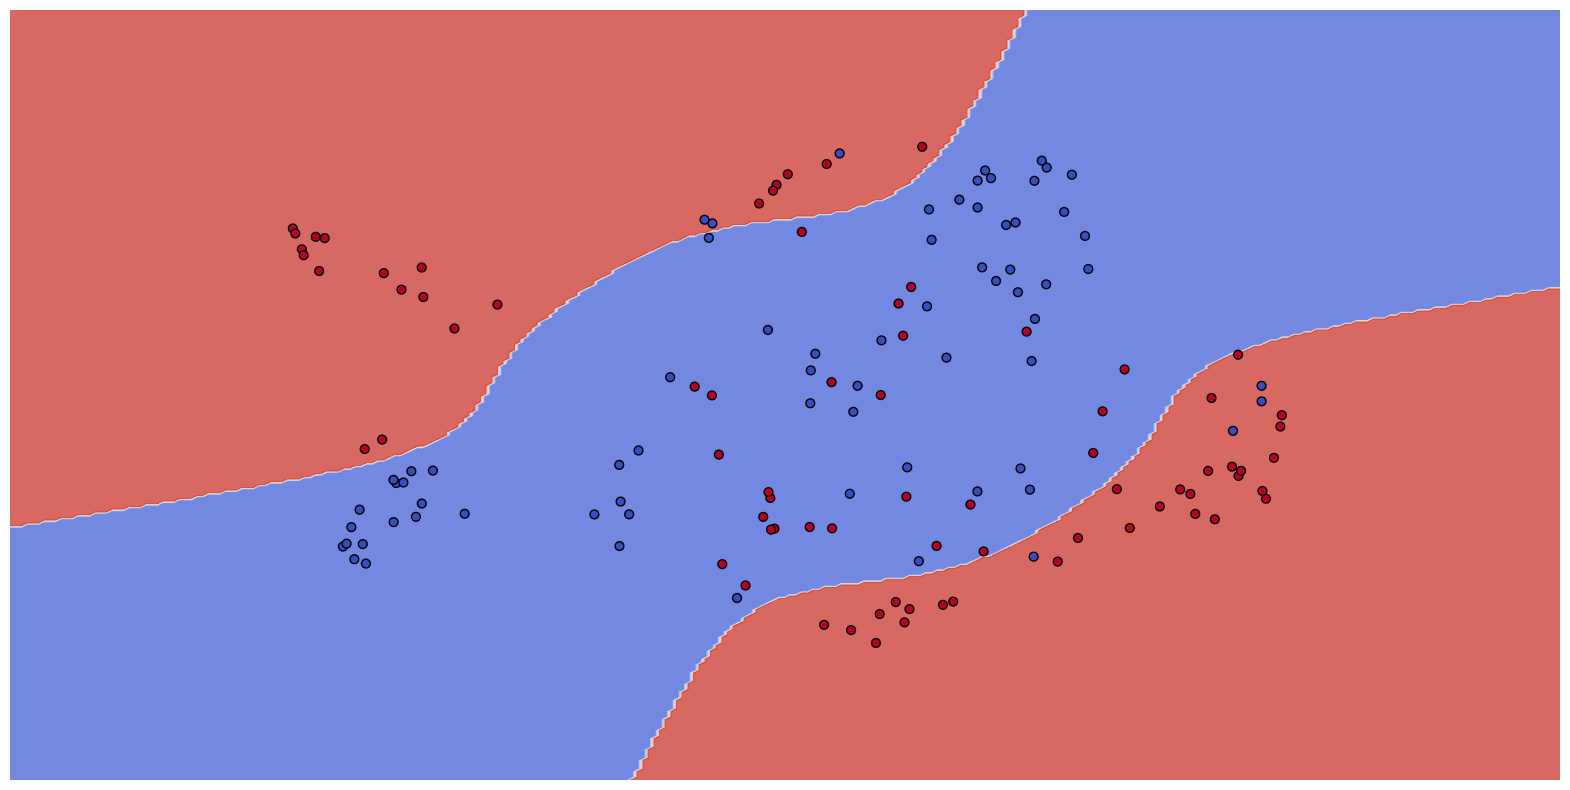

In [15]:
plot_results(features, targets, best_svc)

# KNN

In [32]:
knn_parameters = {
    'n_neighbors': np.linspace(5, 15, 10, dtype=np.int32),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['distance', 'uniform'],
    'p': [1, 2]
}

clf_knn = GridSearchCV(KNeighborsClassifier(), knn_parameters)

In [33]:
clf_knn.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 15]),
                         'p': [1, 2], 'weights': ['distance', 'uniform']})

In [34]:
clf_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [35]:
print(classification_report(y_train, clf_knn.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        49
           1      1.000     1.000     1.000        53

    accuracy                          1.000       102
   macro avg      1.000     1.000     1.000       102
weighted avg      1.000     1.000     1.000       102



In [36]:
print(classification_report(y_test, clf_knn.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.842     0.762     0.800        21
           1      0.800     0.870     0.833        23

    accuracy                          0.818        44
   macro avg      0.821     0.816     0.817        44
weighted avg      0.820     0.818     0.817        44



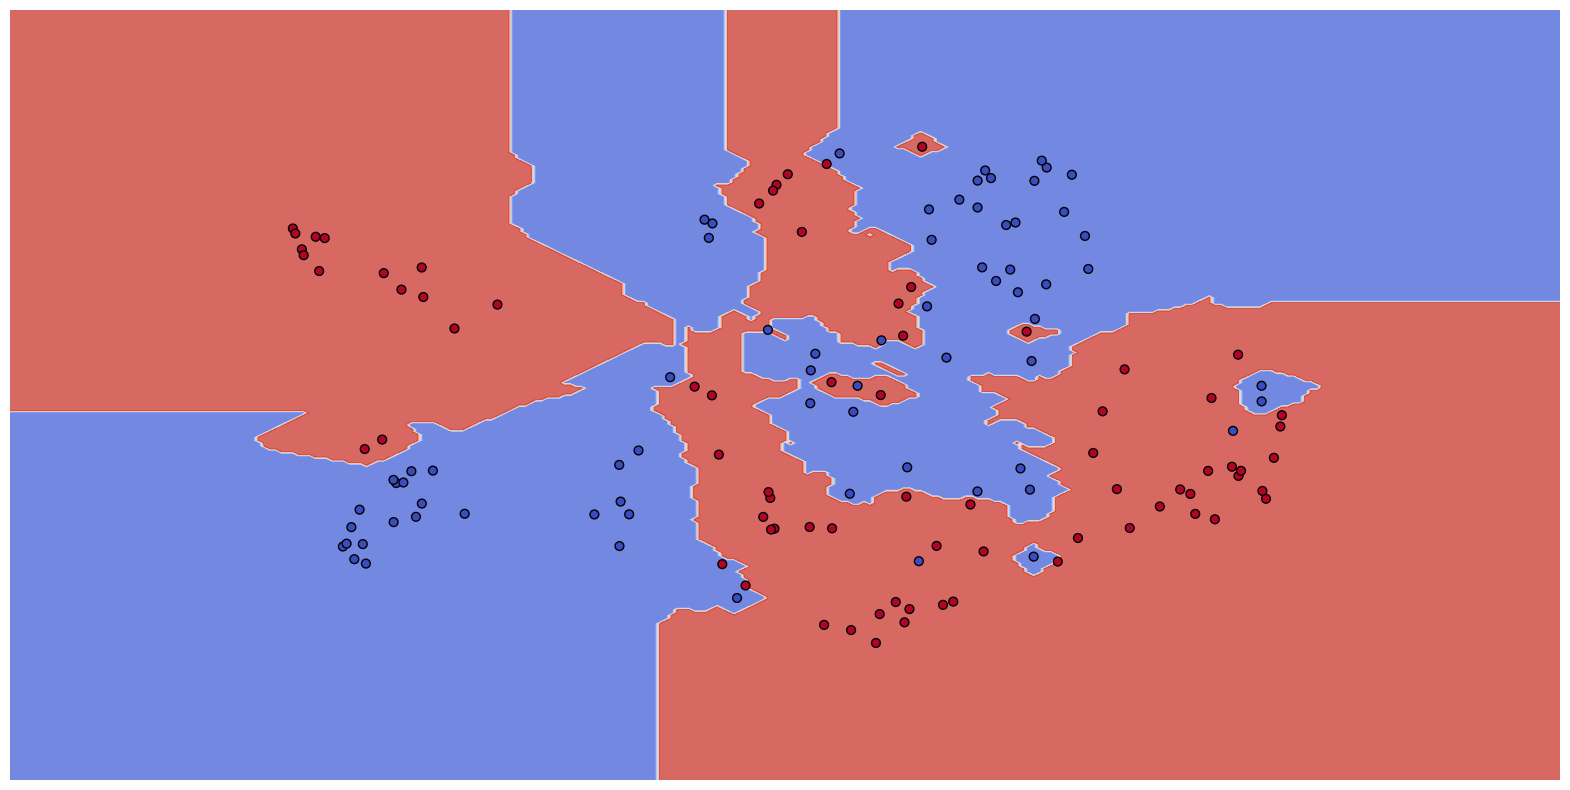

In [37]:
plot_results(features, targets, clf_knn)

# RandomForest

In [23]:
rf_parameters = {
    'n_estimators': np.linspace(5, 50, 10, dtype=np.int32),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(5, 10, 5, dtype=np.int32),
}

clf_rf = GridSearchCV(RandomForestClassifier(), rf_parameters)

In [24]:
clf_rf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5,  6,  7,  8, 10]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])})

In [25]:
clf_rf.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 15}

In [26]:
print(classification_report(y_train, clf_rf.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.979     0.939     0.958        49
           1      0.945     0.981     0.963        53

    accuracy                          0.961       102
   macro avg      0.962     0.960     0.961       102
weighted avg      0.961     0.961     0.961       102



In [27]:
print(classification_report(y_test, clf_rf.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.818     0.857     0.837        21
           1      0.864     0.826     0.844        23

    accuracy                          0.841        44
   macro avg      0.841     0.842     0.841        44
weighted avg      0.842     0.841     0.841        44



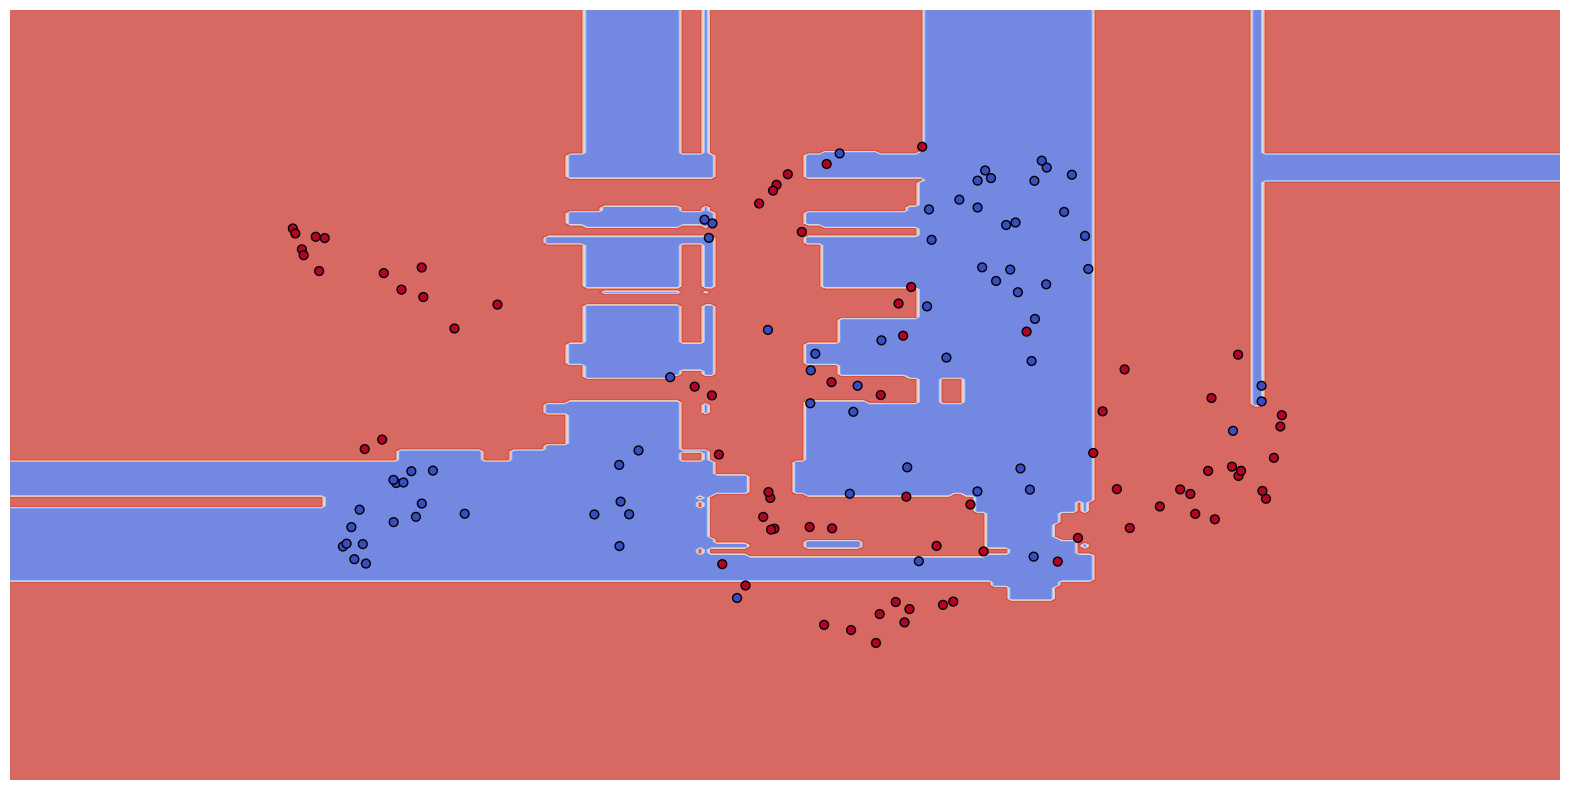

In [28]:
plot_results(features, targets, clf_rf)

# Compare

In [29]:
def plot_bars(features, targets):
    svc_accuracy = round(accuracy_score(targets, best_svc.predict(features)) * 100, 1)
    knn_accuracy = round(accuracy_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_accuracy = round(accuracy_score(targets, clf_rf.predict(features)) * 100, 1)

    svc_precision = round(precision_score(targets, best_svc.predict(features)) * 100, 1)
    knn_precision = round(precision_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_precision = round(precision_score(targets, clf_rf.predict(features)) * 100, 1)

    svc_f1 = round(f1_score(targets, best_svc.predict(features)) * 100, 1)
    knn_f1 = round(f1_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_f1 = round(f1_score(targets, clf_rf.predict(features)) * 100, 1)

    svc_recall = round(recall_score(targets, best_svc.predict(features)) * 100, 1)
    knn_recall = round(recall_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_recall = round(recall_score(targets, clf_rf.predict(features)) * 100, 1)

    labels = ['accuracy', 'precision', 'recall', 'f1']
    svc_metrics = [svc_accuracy, svc_precision, svc_recall, svc_f1]
    knn_metrics = [knn_accuracy, knn_precision, knn_recall, knn_f1]
    rf_metrics = [rf_accuracy, rf_precision, rf_recall, rf_f1]

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots()

    fig.set_size_inches(12, 5)

    svc_bar = ax.bar(x-width-0.01, svc_metrics, width, label='SVC')
    knn_bar = ax.bar(x, knn_metrics, width, label='KNN')
    rf_bar = ax.bar(x+width+0.01, rf_metrics, width, label='RF')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores, %')
    ax.set_title('Scores for SVC, KNN, RF')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=3)

    ax.bar_label(svc_bar)
    ax.bar_label(knn_bar)
    ax.bar_label(rf_bar)

    fig.tight_layout()

    plt.show()

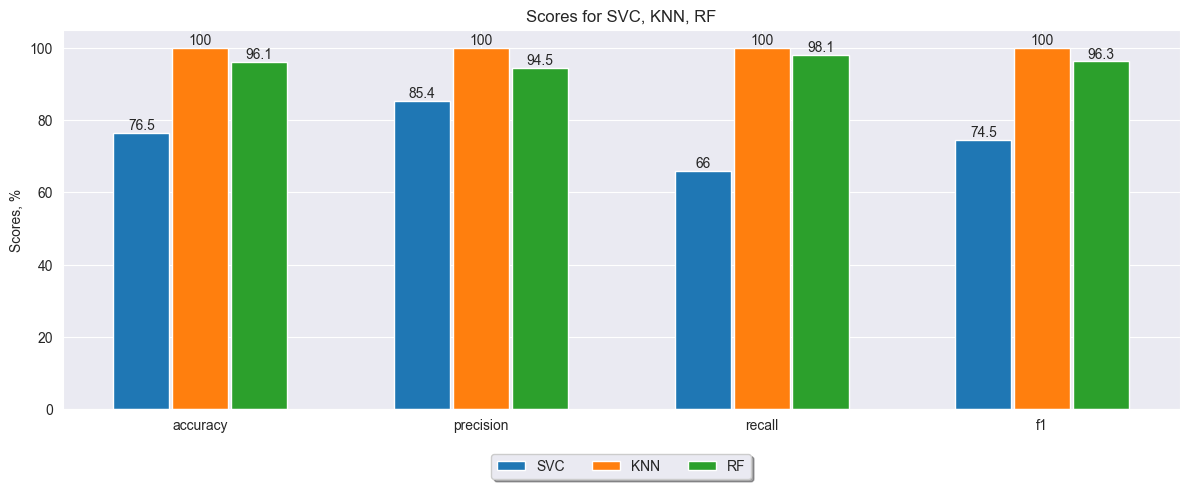

In [30]:
plot_bars(x_train, y_train)

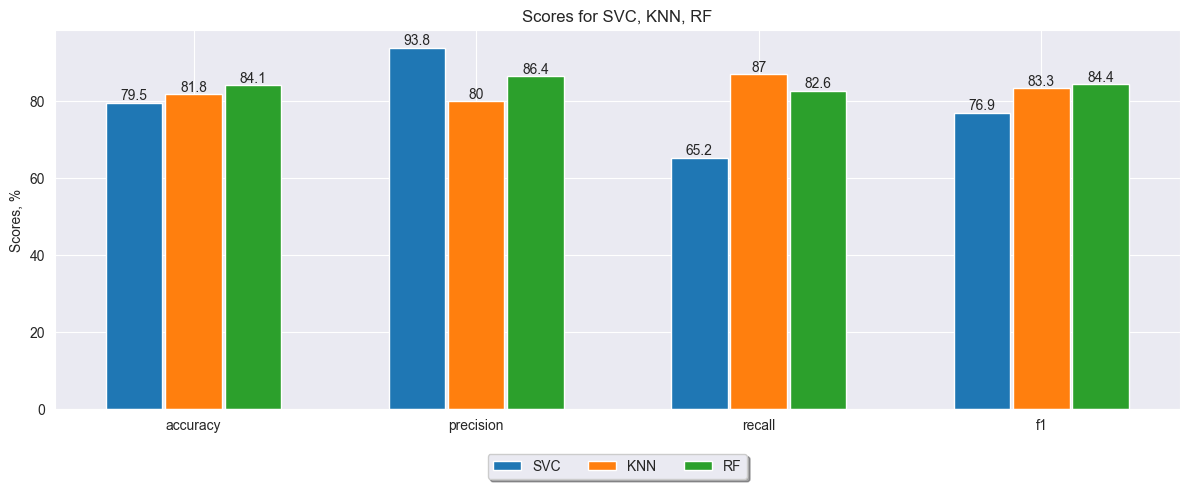

In [31]:
plot_bars(x_test, y_test)